In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
---
# Copiar Dataset

In [6]:
!unzip /content/drive/MyDrive/Proyecto_IA_V1/Dataset.zip -d /content/Dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/Martin/2859.jpg  
  inflating: /content/Dataset/Martin/286.jpg  
  inflating: /content/Dataset/Martin/2860.jpg  
  inflating: /content/Dataset/Martin/2861.jpg  
  inflating: /content/Dataset/Martin/2862.jpg  
  inflating: /content/Dataset/Martin/2863.jpg  
  inflating: /content/Dataset/Martin/2864.jpg  
  inflating: /content/Dataset/Martin/2865.jpg  
  inflating: /content/Dataset/Martin/2866.jpg  
  inflating: /content/Dataset/Martin/2867.jpg  
  inflating: /content/Dataset/Martin/2868.jpg  
  inflating: /content/Dataset/Martin/2869.jpg  
  inflating: /content/Dataset/Martin/287.jpg  
  inflating: /content/Dataset/Martin/2870.jpg  
  inflating: /content/Dataset/Martin/2871.jpg  
  inflating: /content/Dataset/Martin/2872.jpg  
  inflating: /content/Dataset/Martin/2873.jpg  
  inflating: /content/Dataset/Martin/2874.jpg  
  inflating: /content/Dataset/Martin/2875.jpg  
  inflating: /content/Dataset/Martin/28

In [ ]:
!ls -l /content/Dataset/Facundo | grep "^-" | wc -l

3364


In [ ]:
!ls -l /content/Dataset/Luisma | grep "^-" | wc -l

3235


In [ ]:
!ls -l /content/Dataset/Martin | grep "^-" | wc -l

4079


In [ ]:
!ls -l /content/Dataset/Matias | grep "^-" | wc -l

2987


---
---
# Imports

In [19]:
import os, pickle, random, cv2

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications import InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import backend as K


# Funciones

In [22]:
def learning_rate_scheduler(epoch, lr):
    return lr * 0.70  # Decaimiento del 30% en cada época

def entrenar(model, train_batch, test_batch, name, epochs=50):
    history = model.fit(
        train_batch,
        epochs=epochs,
        validation_data=test_batch,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                f'checkpoints/model_{name}',
                save_best_only=True
            ),

            tf.keras.callbacks.EarlyStopping(   # Terminar automaticamente
                patience=10,
            ),

            tf.keras.callbacks.LearningRateScheduler(   # Reducir de a poco el learning rate por cada epoca
                learning_rate_scheduler,      # Funcion que reduce el lr
            ),

            tf.keras.callbacks.ReduceLROnPlateau(   # Reducir el learning rate si no hay mejoras
                factor=0.80,      # Bajar 80% el lr
                patience=3,       # Cada 5 epocas
                verbose=1
            ),
        ]
    )


    # Guardar el historial
    directorio = f'histories/'

    if not os.path.exists(directorio):
        os.makedirs(directorio)

    with open(f'{directorio}/model_{name}.pkl', 'wb') as file:
        pickle.dump(history, file)

    return history

#-------------------------------------------------------------------------------

def g_train_loss(history, name=""):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title(name)
    plt.legend()


def g_train_accuracy(history, name=""):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.title(name)
    plt.legend()


def g_matriz_confusion(model, train_batch, classes, name=""):
    X, y_true = next(train_batch)


    if len(classes.values()) == 2:
        y_pred = (model.predict(X) > 0.5).astype(int)

    else:
        y_pred = np.argmax(model.predict(X), axis=1)
        y_true = np.argmax(y_true, axis=1)


    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=True,
        yticklabels=True,
        cbar=False
    )

    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas Verdaderas')
    plt.title(name)

#-------------------------------------------------------------------------------

def load_random_test_image(test_dir, target_size, classes):
    random_class = random.choice(list(classes.values()))
    class_dir = os.path.join(test_dir, random_class)
    random_image = random.choice(os.listdir(class_dir))

    img_path = os.path.join(class_dir, random_image)
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = img / 255.0  # Normaliza la imagen
    img = np.expand_dims(img, axis=0)  # Añade una dimensión de lote

    return img, random_class, img_path

#-------------------------------------------------------------------------------

def predecir(dir, clases, model):
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    for i in range(6):
        random_test_image, true_class, path = load_random_test_image(dir, (224, 224), clases)
        prediction = model.predict(random_test_image)
        predicted_class = clases[np.argmax(prediction)]
        print(prediction)

        row = i // 3
        col = i % 3
        axs[row, col].imshow(random_test_image[0])
        axs[row, col].set_title(f"Clase Verdadera: {true_class}\nClase Predicha: {predicted_class}")

    # Ajustar espaciado y mostrar la figura
    plt.tight_layout()
    plt.show()


#-------------------------------------------------------------------------------

def mostrar_fotos(train_batch, clases):
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))

    for i in range(16):
        random_image, true_class = train_batch[i]

        if len(clases.values()) > 2:    # Clasificación multiclase
          true_class = np.argmax(true_class, axis=1)

        row = i // 4  # Fila (0, 1, 2 o 3)
        col = i % 4   # Columna (0, 1, 2 o 3)
        axs[row, col].imshow(random_image[0])
        axs[row, col].set_title(f"\n\nClase Verdadera: {clases[int(true_class[0])]}")

#-------------------------------------------------------------------------------

def gradCAM(orig, model, capa, intensity=0.5, res=250):
  img = image.load_img(orig, target_size=(224, 224))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(preds)
  predicted_class = classes[np.argmax(preds)]
  print(predicted_class)

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer(capa)
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape(last_conv_layer.shape[1:3])

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  # cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
  cv2_imshow(cv2.resize(img, (res, res)))

---
---
# 1 Preparación del Dataset


In [ ]:
tf.random.set_seed(42)

dir = '/content/Dataset/'
min = 999999

classes = os.listdir(dir)

for clase in classes:
    cant = len(os.listdir(dir + clase))
    if cant < min:
        min = cant

print(min)

for clase in classes:
    images = os.listdir(dir + clase)
    cant = len(images)
    res = cant - min
    if res > 0:
        random.shuffle(images)  # Mezclar la lista de imágenes aleatoriamente
        for i in range(res):
            image = images[i]
            file_path = os.path.join(dir, clase, image)
            # print('Borrando', file_path)
            os.remove(file_path)

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=[0.5, 2.0],  # Ajuste de brillo
)

train_batch = train_generator.flow_from_directory(
    dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',   #Usamos categorical para referirnos a que son más de dos clases
    subset='training',    # Esto carga el conjunto de entrenamiento
)

test_batch = train_generator.flow_from_directory(
    dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Esto carga el conjunto de prueba
)

Found 9560 images belonging to 4 classes.
Found 2388 images belonging to 4 classes.


## Clases

In [13]:
classes = train_batch.class_indices
classes = {v: k for k, v in classes.items()}
print(classes)   # {0: 'Facundo', 1: 'Luisma', 2: 'Martin', 3: 'Matias'}

{0: 'Facundo', 1: 'Luisma', 2: 'Martin', 3: 'Matias'}


In [ ]:
image_counts = {class_name: 0 for class_name in classes.values()}

for class_index, class_name in classes.items():
    class_dir = os.path.join(dir, class_name)  # Directorio de la clase
    image_counts[class_name] = len(os.listdir(class_dir))

for class_name, count in image_counts.items():
    print(f'Clase: {class_name}, Número de imágenes: {count}')

Clase: Facundo, Número de imágenes: 2987
Clase: Luisma, Número de imágenes: 2987
Clase: Martin, Número de imágenes: 2987
Clase: Matias, Número de imágenes: 2987


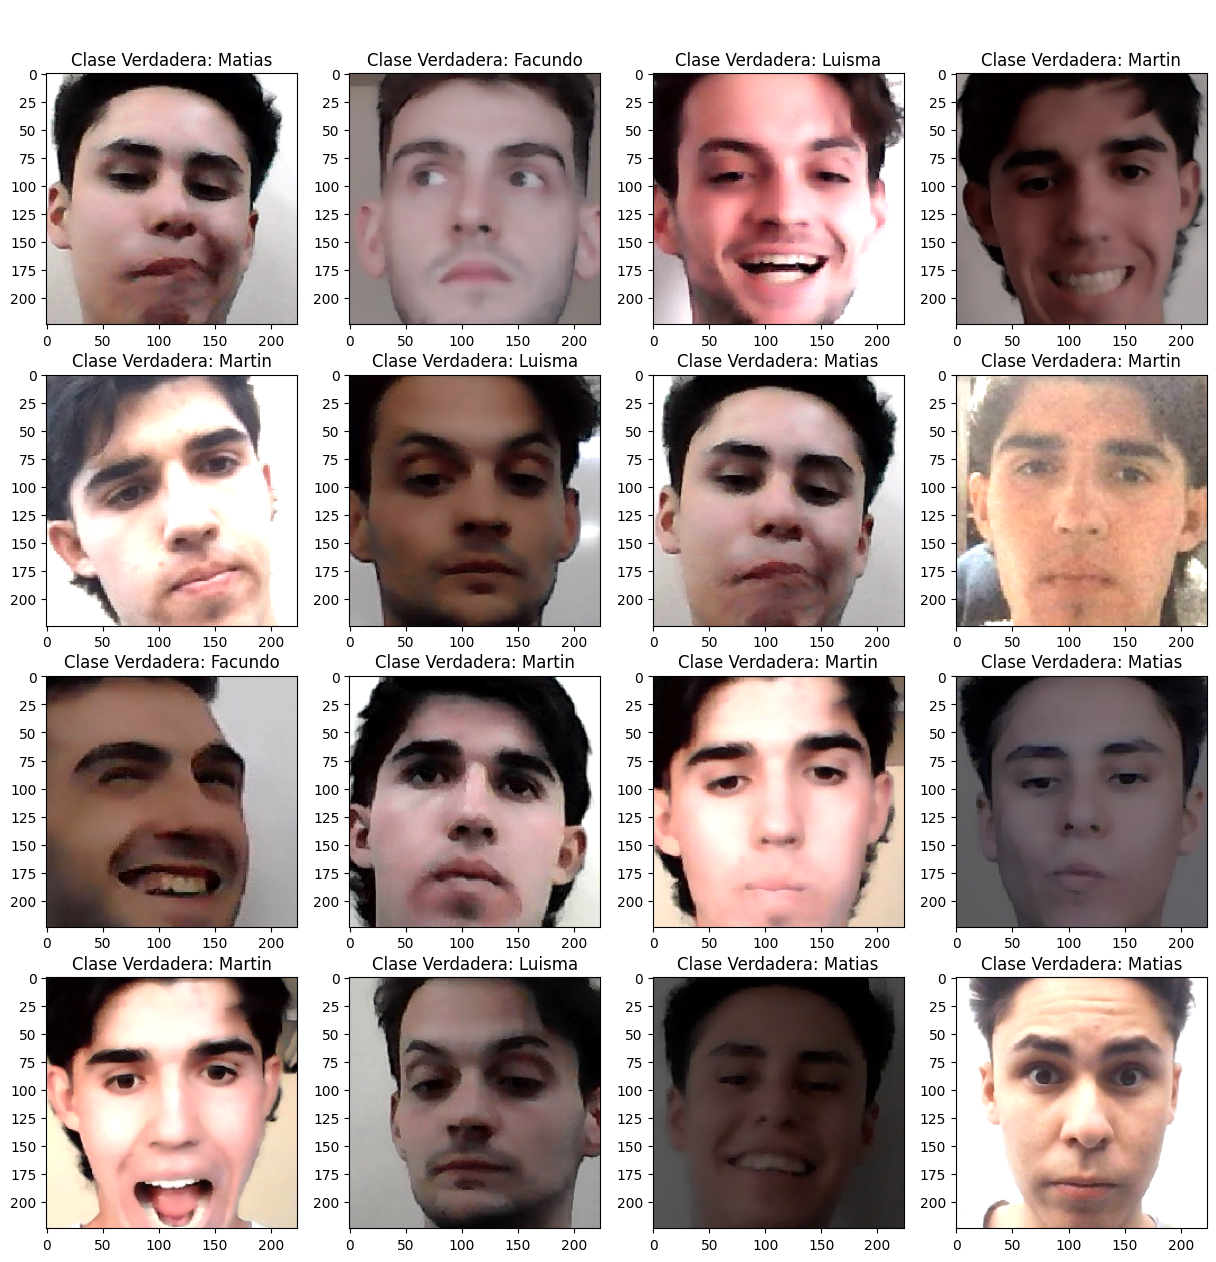

In [ ]:
mostrar_fotos(train_batch, classes)

---
---
# 2.A Modelo Pre-Entrenado (InceptionV3)

In [ ]:
base_model_InceptionV3 = InceptionV3(
    include_top=False,    # Sin la parte de salida
    weights='imagenet',
)

base_model_InceptionV3.trainable = False

---
---
# 3.A Nuestro Modelo


In [ ]:
model_InceptionV3 = tf.keras.Sequential([

    tf.keras.layers.Input(shape=([224,224,3])),

    base_model_InceptionV3,

    tf.keras.layers.Conv2D(192, (1, 1), activation='relu'),
    tf.keras.layers.Dropout((0.50)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_InceptionV3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 conv2d_189 (Conv2D)         (None, 5, 5, 192)         393408    
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 192)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4800)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1229056   
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                      

---
---
# 4.A Compilación

In [ ]:
model_InceptionV3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy'],
)

---
---
# 5.A Entrenamiento

In [ ]:
history_InceptionV3 = entrenar(model_InceptionV3, train_batch, test_batch, "InceptionV3")

---
## Guardar modelo entrenado

In [ ]:
!cp -r /content/checkpoints/model_InceptionV3 /content/drive/MyDrive/Proyecto_IA_V1

updating: content/checkpoints/model_InceptionV3/ (stored 0%)
updating: content/checkpoints/model_InceptionV3/variables/ (stored 0%)
updating: content/checkpoints/model_InceptionV3/variables/variables.data-00000-of-00001 (deflated 7%)
updating: content/checkpoints/model_InceptionV3/variables/variables.index (deflated 76%)
updating: content/checkpoints/model_InceptionV3/keras_metadata.pb (deflated 96%)
updating: content/checkpoints/model_InceptionV3/saved_model.pb (deflated 92%)
updating: content/checkpoints/model_InceptionV3/assets/ (stored 0%)
updating: content/checkpoints/model_InceptionV3/fingerprint.pb (stored 0%)


---
## Cargar Modelo

In [11]:
model_InceptionV3 = tf.keras.models.load_model("/content/drive/MyDrive/Proyecto_IA_V1/InceptionV3_RGB")

---
## Cargar historial

In [ ]:
with open('/content/drive/MyDrive/Proyecto_IA_V1/InceptionV3_RGB.pkl', 'rb') as file:
    history_InceptionV3 = pickle.load(file)

---
## Evaluar

In [ ]:
model_InceptionV3.evaluate(test_batch)

75/75 [==============================] - 21s 150ms/step - loss: 0.0835 - accuracy: 0.9786


[0.08346746116876602, 0.9786432385444641]

---
---
# 2.B Modelo Pre-Entrenado (MobileNetV2)

In [ ]:
base_model_MobileNetV2 = MobileNetV2(
    weights='imagenet',
    include_top=False
)

base_model_MobileNetV2.trainable = False

---
---
# 3.B Nuestro Modelo

In [ ]:
model_MobileNetV2 = tf.keras.Sequential([

    tf.keras.layers.Input(shape=([224,224,3])),

    base_model_MobileNetV2,

    tf.keras.layers.Conv2D(192, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout((0.50)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_MobileNetV2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                                 
 conv2d_664 (Conv2D)         (None, 5, 5, 192)         2212032   
                                                                 
 dropout_15 (Dropout)        (None, 5, 5, 192)         0         
                                                                 
 flatten_13 (Flatten)        (None, 4800)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               1229056   
                                                                 
 dense_17 (Dense)            (None, 4)                 1028      
                                                     

---
---
# 4.B Compilación

In [ ]:
model_MobileNetV2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy'],
)

---
---
# 5.B Entrenamiento


In [ ]:
history_MobileNetV2 = entrenar(model_MobileNetV2, train_batch, test_batch, "MobileNetV2")

---
## Guardar modelo entrenado

In [ ]:
!cp -r /content/checkpoints/model_MobileNetV2 /content/drive/MyDrive/Proyecto_IA_V1

  adding: content/checkpoints/model_MobileNetV2/ (stored 0%)
  adding: content/checkpoints/model_MobileNetV2/keras_metadata.pb (deflated 96%)
  adding: content/checkpoints/model_MobileNetV2/assets/ (stored 0%)
  adding: content/checkpoints/model_MobileNetV2/fingerprint.pb (stored 0%)
  adding: content/checkpoints/model_MobileNetV2/variables/ (stored 0%)
  adding: content/checkpoints/model_MobileNetV2/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: content/checkpoints/model_MobileNetV2/variables/variables.index (deflated 76%)
  adding: content/checkpoints/model_MobileNetV2/saved_model.pb (deflated 91%)


---
## Cargar modelo

In [15]:
model_MobileNetV2 = tf.keras.models.load_model("/content/drive/MyDrive/Proyecto_IA_V1/model_MobileNetV2")

---
## Cargar historial

In [ ]:
with open('/content/drive/MyDrive/Proyecto_IA_V1/model_MobileNetV2.pkl', 'rb') as file:
    history_MobileNetV2 = pickle.load(file)

---
## Evaluar

In [ ]:
model_MobileNetV2.evaluate(test_batch)

75/75 [==============================] - 12s 138ms/step - loss: 0.2114 - accuracy: 0.9267


[0.21144279837608337, 0.9267169237136841]

---
---
# 6 Métricas

## Grafico de perdida

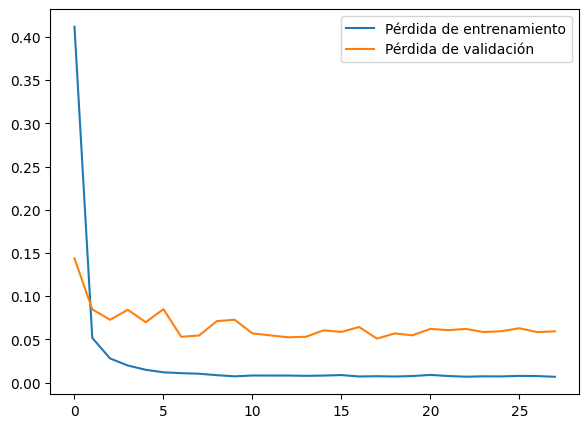

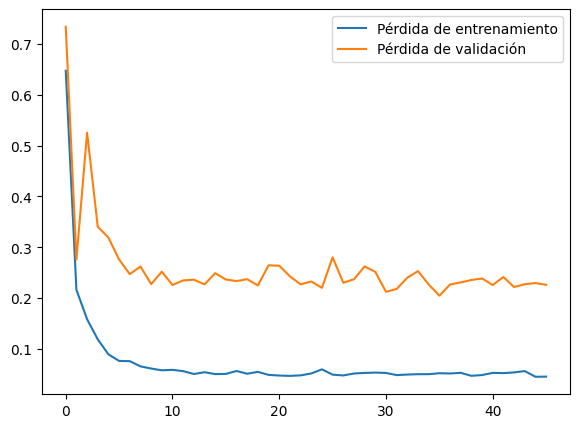

In [ ]:
g_train_loss(history_InceptionV3)
g_train_loss(history_MobileNetV2)

## Grafico de presición

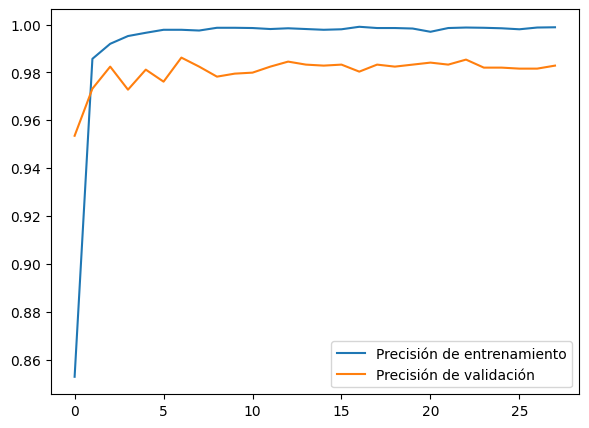

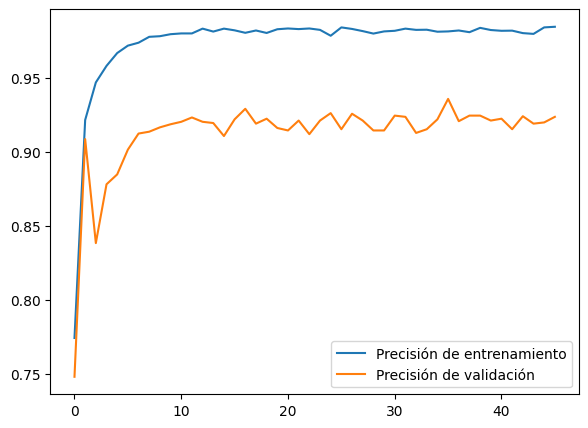

In [ ]:
g_train_accuracy(history_InceptionV3)
g_train_accuracy(history_MobileNetV2)

## Matriz de confusión

1/1 [==============================] - 1s 1s/step


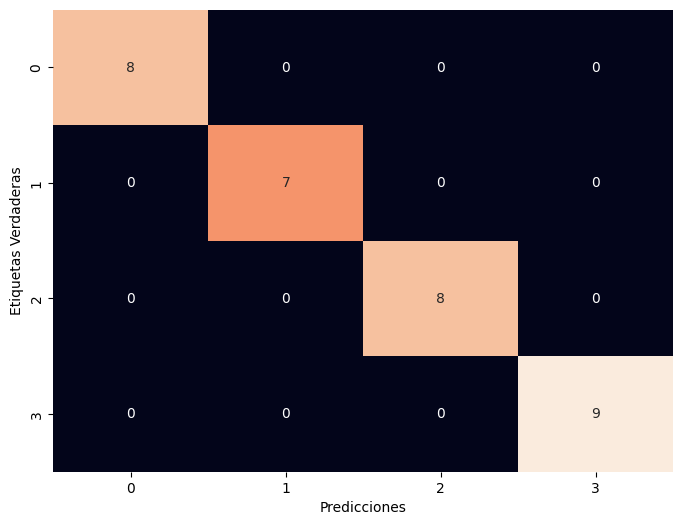

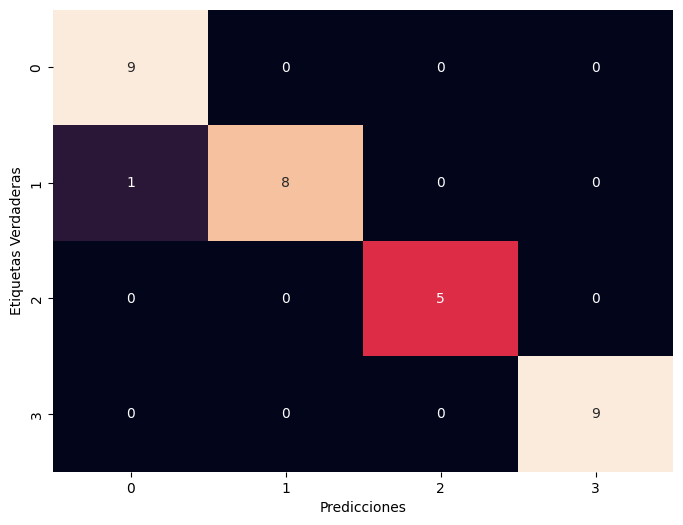

In [ ]:
g_matriz_confusion(model_InceptionV3, test_batch, classes)
g_matriz_confusion(model_MobileNetV2, test_batch, classes)

---
---
# 7 Predicción

1/1 [==============================] - 0s 26ms/step
[[0.00626635 0.9664158  0.01626727 0.01105054]]
1/1 [==============================] - 0s 29ms/step
[[9.99980211e-01 8.23216124e-06 1.08591075e-05 7.55667941e-07]]
1/1 [==============================] - 0s 28ms/step
[[3.9476188e-05 6.3722197e-05 2.7745453e-05 9.9986899e-01]]
1/1 [==============================] - 0s 26ms/step
[[4.3976030e-05 6.1545376e-07 1.7304626e-05 9.9993813e-01]]
1/1 [==============================] - 0s 26ms/step
[[6.8968866e-06 1.8486410e-03 3.4926197e-06 9.9814105e-01]]
1/1 [==============================] - 0s 29ms/step
[[8.3958732e-08 2.3737738e-07 1.2769958e-04 9.9987197e-01]]


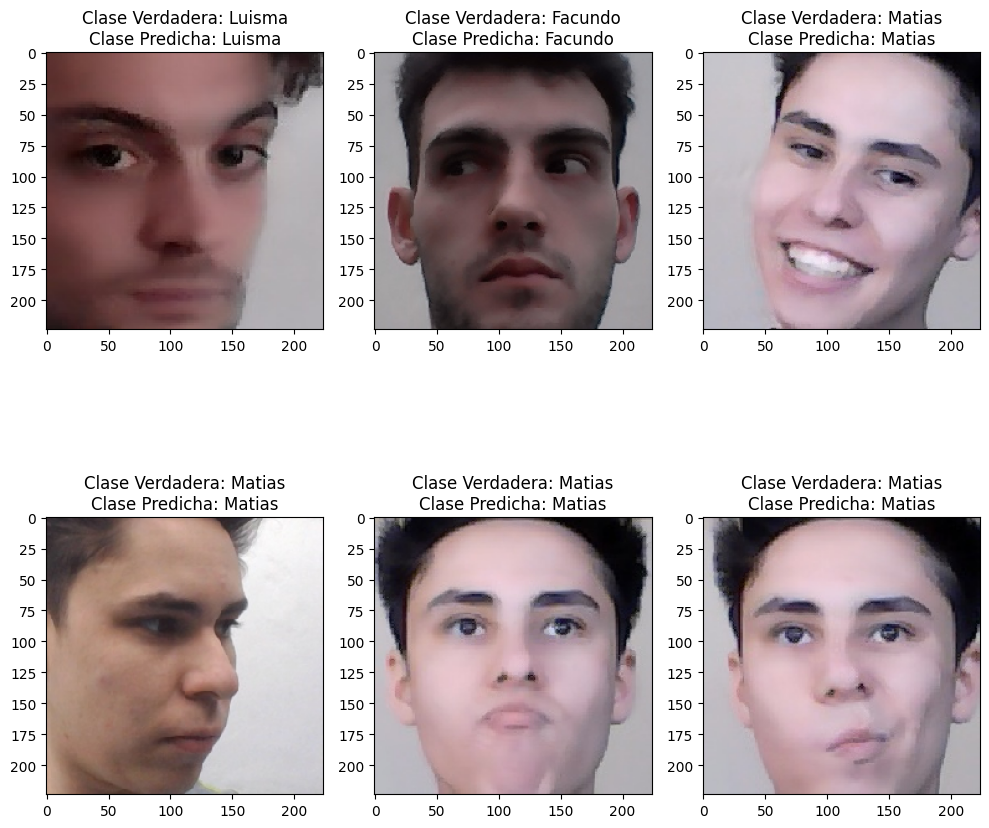

1/1 [==============================] - 0s 23ms/step
[[9.9999976e-01 5.8751182e-09 1.8000970e-08 2.4315869e-07]]
1/1 [==============================] - 0s 23ms/step
[[2.9058529e-02 6.1185245e-05 9.1167849e-01 5.9201792e-02]]
1/1 [==============================] - 0s 25ms/step
[[5.6503410e-08 1.0000000e+00 1.0720479e-11 2.4372648e-08]]
1/1 [==============================] - 0s 23ms/step
[[4.5255823e-05 9.1369984e-06 6.2696363e-06 9.9993932e-01]]
1/1 [==============================] - 0s 27ms/step
[[4.0287950e-06 9.9999583e-01 3.5674814e-11 6.7849477e-08]]
1/1 [==============================] - 0s 26ms/step
[[1.2914392e-06 9.9990475e-01 2.2522946e-10 9.3896437e-05]]


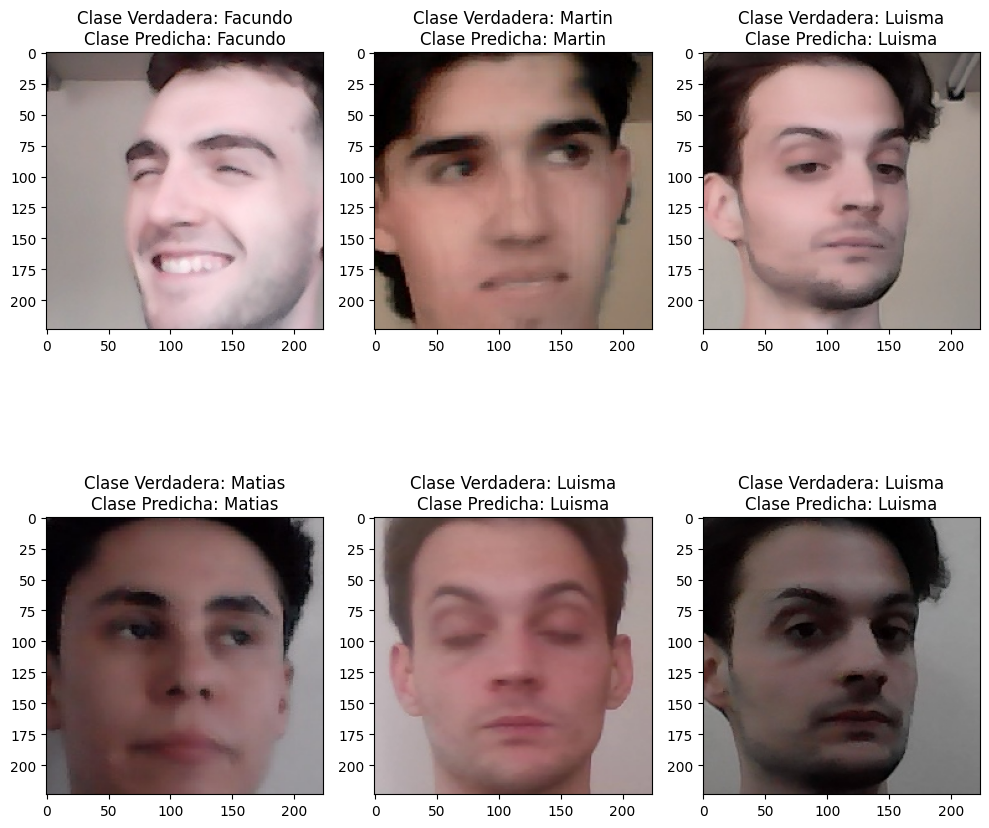

In [ ]:
predecir(
    dir = '/content/Dataset/',
    clases = classes,
    model = model_InceptionV3,
)
predecir(
    dir = '/content/Dataset/',
    clases = classes,
    model = model_MobileNetV2,
)

---
---
# 8 Mapa de calor

Model InceptionV3
1/1 [==============================] - 0s 30ms/step
[[9.9999988e-01 9.4259001e-08 2.1940614e-09 1.7002514e-09]]
Facundo


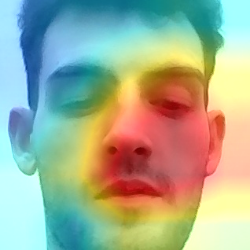

Model MobileNetV2
1/1 [==============================] - 0s 23ms/step
[[9.9999940e-01 5.4004539e-07 8.6453911e-10 1.2030263e-08]]
Facundo


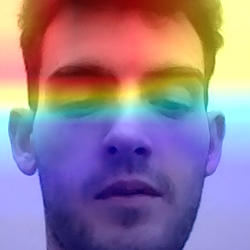

Model InceptionV3
1/1 [==============================] - 0s 29ms/step
[[6.8205409e-05 3.8152751e-07 9.9987829e-01 5.3155727e-05]]
Martin


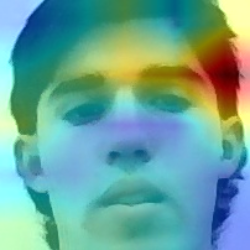

Model MobileNetV2
1/1 [==============================] - 0s 22ms/step
[[2.0311123e-08 1.0697904e-08 1.0000000e+00 1.9212862e-10]]
Martin


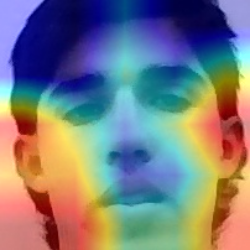

Model InceptionV3
1/1 [==============================] - 0s 26ms/step
[[9.9993622e-01 2.2027996e-06 5.4137934e-05 7.4362706e-06]]
Facundo


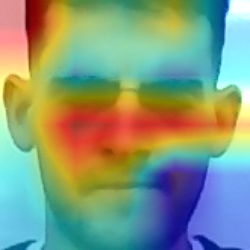

Model MobileNetV2
1/1 [==============================] - 0s 23ms/step
[[8.1368506e-01 6.8809626e-05 6.4834528e-02 1.2141166e-01]]
Facundo


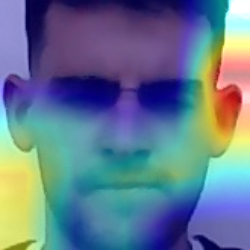

Model InceptionV3
1/1 [==============================] - 0s 28ms/step
[[6.2686443e-09 6.2004887e-07 9.9999142e-01 7.9338779e-06]]
Martin


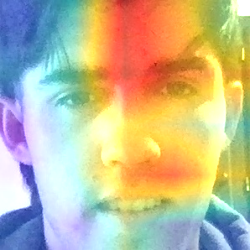

Model MobileNetV2
1/1 [==============================] - 0s 22ms/step
[[2.1654091e-06 4.6547136e-10 9.9999785e-01 1.2409924e-08]]
Martin


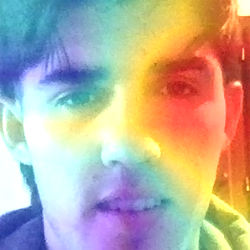

Model InceptionV3
1/1 [==============================] - 0s 28ms/step
[[9.9979419e-01 3.6281141e-05 9.1429285e-07 1.6868861e-04]]
Facundo


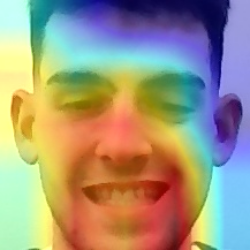

Model MobileNetV2
1/1 [==============================] - 0s 35ms/step
[[1.0000000e+00 3.5573923e-15 2.1350204e-15 8.5593370e-14]]
Facundo


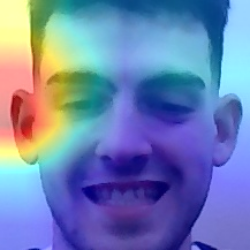

Model InceptionV3
1/1 [==============================] - 0s 30ms/step
[[1.5113767e-07 4.6585563e-07 9.9999762e-01 1.8276422e-06]]
Martin


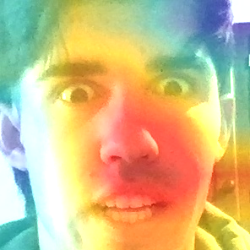

Model MobileNetV2
1/1 [==============================] - 0s 25ms/step
[[5.5171462e-04 1.7088573e-09 9.9944693e-01 1.2910276e-06]]
Martin


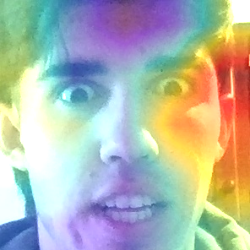

In [31]:

for n in range(6):
    random_test_image, true_class , image_path = load_random_test_image('/content/Dataset/', (224, 224), classes)
    print("Model InceptionV3")
    gradCAM(image_path, model_InceptionV3, "conv2d_663")

    print("Model MobileNetV2")
    gradCAM(image_path, model_MobileNetV2, "conv2d")